### L1_1_KNN

Cs231n: KNN in Python.

In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline ###KEY
plt.rcParams['figure.figsize'] = (10.0,8.0) #set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray' #灰度空间

#重新加载python modules,  ###KEY
%load_ext autoreload
%autoreload 2

In [5]:
#加载数据（cifar10）并核对
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'   #6万个数据，5万（5个batch），1万测试
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

#核对，print 下
print('Training data shape: ',X_train.shape)
print('Training labels shape: ',y_train.shape)
print('Test data shape: ',X_test.shape)
print('Test labels shape: ',y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


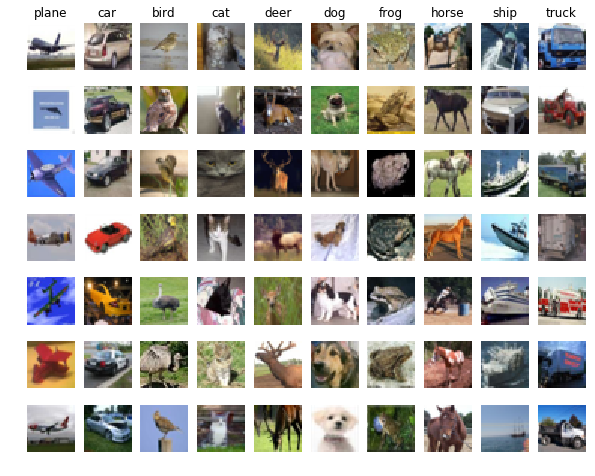

In [7]:
#查看cifar10中的一些图像
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
num_classes = len(classes)
sample_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train ==y)
    idxs = np.random.choice(idxs,sample_per_class, replace=False) #replace 是否可以出现重复样本
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(sample_per_class, num_classes, plt_idx) #plt_idx  第几个图
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [11]:
#cifar10 数据量太大，我们只抽一部分实验:train 5000 test:500 取前面的
num_train = 5000
mask = list(range(num_train))
X_train = X_train[mask]
y_train = y_train[mask]
#print(X_train.shape)   (5000, 32, 32, 3)
num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [12]:
#图像转化为列向量
X_train = np.reshape(X_train, (X_train.shape[0],-1)) #-1: m每幅图转化为列向量One shape dimension can be -1. In this case, the value is inferred from the length of the array and remaining dimensions.
X_test = np.reshape(X_test,(X_test.shape[0],-1))
print(X_train.shape, X_test.shape)   #(5000, 3072) (500, 3072)

(5000, 3072) (500, 3072)


In [16]:
#用KNN进行分类(该分类器存储数据；比较)
from cs231n.classifiers import KNearestNeighbor
classifier = KNearestNeighbor()
classifier.train(X_train,y_train)

In [19]:
#Lets begin with computing the distance matrix between all training and test examples. 
#For example, if there are Ntr training examples and Nte test examples, 
#this stage should result in a Nte x Ntr matrix where each element (i,j) is the distance 
#between the i-th test and j-th train example.

#（改写KNearestNeighbor.py函数后）测试集生成距离矩阵
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


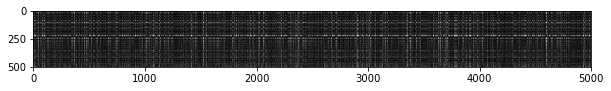

In [20]:
#Visualize the distance matirx: each row is a single test sample and its distances to 
#training examples
plt.imshow(dists,interpolation='none')
plt.show()

In [21]:
#测试集预测
#调整最近邻参数 k=1
y_test_pred = classifier.predict_labels(dists,k=1)
#正确率
num_correct = np.sum(y_test_pred==y_test)
accuracy = float(num_correct)/num_test
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [23]:
#调整最近邻参数 k=5
y_test_pred = classifier.predict_labels(dists,k=5)
#正确率
num_correct = np.sum(y_test_pred==y_test)
accuracy = float(num_correct)/num_test
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 131 / 500 correct => accuracy: 0.262000


In [25]:
#一个循环实现的求距离矩阵
#speed up distance matrix computation by using partial vectorization
# with one loop. 
dists_one = classifier.compute_distances_one_loop(X_test)
#判断两个矩阵是否相似
difference = np.linalg.norm(dists-dists_one, ord='fro') #Matrix or vector norm 'fro':F范数，平方和开根号
print('Difference was: %f' % (difference,))
if difference <0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matirces are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [30]:
#无循环，向量化求距离
dists_two = classifier.compute_distances_no_loops(X_test)

#判断生成的矩阵是否一样
different = np.linalg.norm(dists-dists_two, ord='fro')
print('Difference was：%f' % (difference,))
if difference <0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was：0.000000
Good! The distance matrices are the same


In [31]:
#比较三种方法的时间：
def time_function(f,*args):
    #call a function f with args and return the time(in seconds) that it took to execute.
    import time
    tic=time.time()
    f(*args)
    toc = time.time()
    return toc-tic
two_loop_time = time_function(classifier.compute_distances_two_loops,X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)
    
no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

Two loop version took 849.017561 seconds
One loop version took 73.435200 seconds
No loop version took 0.314018 seconds


In [33]:
#交叉验证
num_folds = 5
k_choices=[1,3,5,8,10,12,15,20,50,100]

X_train_folds = []
y_train_folds = []
#array_split()
X_train_folds = np.array_split(X_train,num_folds, axis=0) #返回list：[arr,arr,arr,arr,arr]（按顺序划分【不太好】）split只能划分可被整除的，array_split不整除也行
y_train_folds = np.array_split(y_train,num_folds, axis=0)

k_to_accuracies = {}

###
for k in k_choices:
    k_to_accuracies[k] = []
    for val_idx in range(num_folds):
        X_val = X_train_folds[val_idx]
        y_val = y_train_folds[val_idx]
        
        X_tra = X_train_folds[:val_idx] + X_train_folds[val_idx + 1:] #list中某个值的前后
        X_tra = np.reshape(X_tra, (X_train.shape[0] - X_val.shape[0], -1))
        y_tra = y_train_folds[:val_idx] + y_train_folds[val_idx + 1:]
        y_tra = np.reshape(y_tra, (X_train.shape[0] - X_val.shape[0],))
        
        classifier.train(X_tra, y_tra)
        y_val_pre = classifier.predict(X_val, k, 0)  #0对应non-loop,向量化计算
        
        right_arr = y_val_pre == y_val
        accuracy = float(np.sum(right_arr)) / y_val.shape[0]
        k_to_accuracies[k].append(accuracy)
###


#print out the computed accuracies
for k in sorted(k_to_accuracies):    #key 排序
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k,accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.246000
k = 3, accuracy = 0.275000
k = 3, accuracy = 0.276000
k = 3, accuracy = 0.267000
k = 3, accuracy = 0.265000
k = 5, accuracy = 0.264000
k = 5, accuracy = 0.272000
k = 5, accuracy = 0.272000
k = 5, accuracy = 0.253000
k = 5, accuracy = 0.262000
k = 8, accuracy = 0.229000
k = 8, accuracy = 0.245000
k = 8, accuracy = 0.256000
k = 8, accuracy = 0.240000
k = 8, accuracy = 0.247000
k = 10, accuracy = 0.232000
k = 10, accuracy = 0.238000
k = 10, accuracy = 0.244000
k = 10, accuracy = 0.222000
k = 10, accuracy = 0.244000
k = 12, accuracy = 0.218000
k = 12, accuracy = 0.228000
k = 12, accuracy = 0.204000
k = 12, accuracy = 0.216000
k = 12, accuracy = 0.221000
k = 15, accuracy = 0.213000
k = 15, accuracy = 0.207000
k = 15, accuracy = 0.218000
k = 15, accuracy = 0.206000
k = 15, accuracy = 0.214000
k = 20, accuracy = 0.197000
k = 20, accu

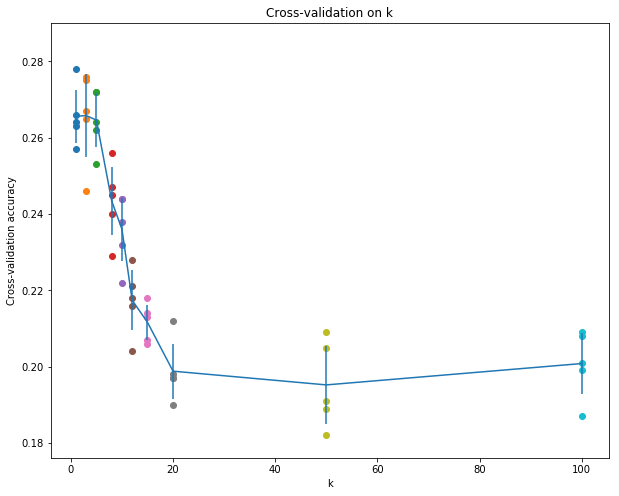

In [42]:
#交叉验证的结果画图
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies),accuracies)
    
#plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices,accuracies_mean,yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [41]:
#由上面的结果，选择最好的k值
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train,y_train)
y_test_pred = classifier.predict(X_test,k=best_k)#第三个参数用默认值0，没有循环

num_correct = np.sum(y_test_pred==y_test)
accuracy = float(num_correct)/num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct,num_test,accuracy))

Got 137 / 500 correct => accuracy: 0.274000
